### Import Requirements

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

#memory management
import gc

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib for plotting
import matplotlib.pyplot as plt

#to impute missing values
from sklearn.preprocessing import Imputer, MinMaxScaler

from sklearn.feature_selection import VarianceThreshold, RFE, SelectFromModel, chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Utility Functions
### Set folder paths for getting input and saving outputs

In [2]:
def setupFolderPaths():    
    #Set input data folder 
    dataFolder = os.getcwd() + os.sep + os.pardir + os.sep + 'ProjectDataFiles'
    if(not os.path.exists(dataFolder)):
        print("Input Data folder not found. Please specify data folder path as dataFolder variable to proceed")
        raise NotADirectoryError

    #Create output folder is it does not exist
    outputFolder = os.getcwd() + os.sep + os.pardir + os.sep + 'CodeOutputs'

    if not os.path.exists(outputFolder):
        os.makedirs(outputFolder)
        print('Output Folder created')
        
    return dataFolder, outputFolder

In [3]:
def readFile(fileName):
    if(not os.path.exists(fileName)):
        raise FileNotFoundError
        
    return pd.read_csv(fileName)

## Replace all the outliers in the input data set with nan

In [4]:
#Function to replace outliers in input data
def replace_outliers(df):
    #Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    if 'CODE_GENDER' in df:
        df = df[df['CODE_GENDER'] != 'XNA']

    #Replace outlier values with nan
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].map(lambda x: x if x <= 0 else np.nan)
    df['REGION_RATING_CLIENT_W_CITY'] = df['REGION_RATING_CLIENT_W_CITY'].map(lambda x: x if x >= 0 else np.nan)
    df['AMT_INCOME_TOTAL'] = df['AMT_INCOME_TOTAL'].map(lambda x: x if x <= 1e8 else np.nan)
    df['AMT_REQ_CREDIT_BUREAU_QRT'] = df['AMT_REQ_CREDIT_BUREAU_QRT'].map(lambda x: x if x <= 10 else np.nan)
    df['OBS_30_CNT_SOCIAL_CIRCLE'] = df['OBS_30_CNT_SOCIAL_CIRCLE'].map(lambda x: x if x <= 40 else np.nan)
    df['OBS_60_CNT_SOCIAL_CIRCLE'] = df['OBS_60_CNT_SOCIAL_CIRCLE'].map(lambda x: x if x <= 50 else np.nan)
    df['DEF_30_CNT_SOCIAL_CIRCLE'] = df['DEF_30_CNT_SOCIAL_CIRCLE'].map(lambda x: x if x <= 100 else np.nan)
    
    return df

## Check For Missing Values

In [5]:
# Function to calculate missing values by columns 
def compute_missing_values(df, sortAscending = False):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=sortAscending).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing value information
        return mis_val_table_ren_columns

In [6]:
#Functions used for plotting and visualizing outliers

# add noise to y axis to avoid overlapping of data points
def rand_jitter(arr):
    nosie = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr))

def plot_feature_distribution(df, column, fileName = ''):
    column_values = df[df[column].notna()][column]
    # group by target
    class_0_values = df[df[column].notna() & (df['TARGET']==0)][column]
    class_1_values = df[df[column].notna() & (df['TARGET']==1)][column]
    class_t_values = df[df[column].notna() & (df['TARGET'].isna())][column]        
    # for features with unique values >= 10
    if len(df[column].value_counts().keys()) >= 10:
        fig, ax = plt.subplots(1, figsize=(15, 4))
        if df[column].dtype == 'object':
            label_encoder = LabelEncoder()
            label_encoder.fit(column_values)
            class_0_values = label_encoder.transform(class_0_values)
            class_1_values = label_encoder.transform(class_1_values)
            class_t_values = label_encoder.transform(class_t_values)
            column_values = label_encoder.transform(column_values)
            plt.xticks(range(len(label_encoder.classes_)), label_encoder.classes_, fontsize=12, rotation='vertical')

        ax.scatter(class_0_values, rand_jitter([0]*class_0_values.shape[0]), label='Class0', s=10, marker='o', color='#7ac143', alpha=1)
        ax.scatter(class_1_values, rand_jitter([10]*class_1_values.shape[0]), label='Class1', s=10, marker='o', color='#fd5c63', alpha=1)
        ax.scatter(class_t_values, rand_jitter([20]*class_t_values.shape[0]), label='Test', s=10, marker='o', color='#037ef3', alpha=0.4)
        ax.set_title(column +' group by target', fontsize=16)
        ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
        ax.set_title(column +' distribution', fontsize=16)
    else:      
        all_categories = list(df[df[column].notna()][column].value_counts().keys())
        bar_width = 0.25
        
        fig, ax = plt.subplots(figsize=(20, 4))
        ax.set_title(column, fontsize=16)
        plt.xlabel('Categories', fontsize=16)
        plt.ylabel('Counts', fontsize=16)

        value_counts = class_0_values.value_counts()
        x_0 = np.arange(len(all_categories))
        y_0 = [value_counts.get(categroy, 0) for categroy in all_categories]
        ax.bar(x_0, y_0, color='#7ac143', width=bar_width, label='class0')

        value_counts = class_1_values.value_counts()
        x_1 = np.arange(len(all_categories))
        y_1 = [value_counts.get(categroy, 0) for categroy in all_categories]
        ax.bar(x_1+bar_width, y_1, color='#fd5c63', width=bar_width, label='class1')
        
        value_counts = class_t_values.value_counts()
        x_2 = np.arange(len(all_categories))
        y_2 = [value_counts.get(categroy, 0) for categroy in all_categories]
        ax.bar(x_2+2*bar_width, y_2, color='#037ef3', width=bar_width, label='test')
        
        ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
        
        for i, v in enumerate(y_0):
            if y_0[i]+y_1[i] == 0:
                ax.text(i - .08, max(y_0)//1.25,  'Missing in Train', fontsize=14, rotation='vertical')
            else:
                ax.text(i - .08, max(y_0)//1.25,  "{:0.1f}%".format(100*y_0[i]/(y_0[i]+y_1[i])), fontsize=14, rotation='vertical')
        
        for i, v in enumerate(y_1):
            if y_0[i]+y_1[i] == 0:
                ax.text(i - .08, max(y_0)//1.25,  'Missing in Train', fontsize=14, rotation='vertical')
            else:
                ax.text(i + bar_width - .08, max(y_0)//1.25, "{:0.1f}%".format(100*y_1[i]/(y_0[i]+y_1[i])), fontsize=14, rotation='vertical')
 
        for i, v in enumerate(y_2):
            if y_2[i] == 0:
                ax.text(i + 2*bar_width - .08, max(y_0)//1.25, 'Missing in Test', fontsize=14, rotation='vertical')
            else:
                ax.text(i + 2*bar_width - .08, max(y_0)//1.25, str(y_2[i]), fontsize=14, rotation='vertical')
        
        plt.xticks(x_0 + 2*bar_width/3, all_categories, fontsize=16)
        
    plt.show()
    plt.savefig(outputFolder + '\\{}{}_distribution.png'.format(column,fileName), bbox_inches='tight')
    plt.close()

### Identify Feature types : Catagorical, Numerical, Integer and Boolean (Flags)

In [7]:
#Function to identify feature types in a given data frame
def identify_feature_types(df, features_to_ignore, verbose = False):
    categorical_features = list(f for f in df.select_dtypes(include='object') if f not in features_to_ignore)
    floatingPoint_features = list(f for f in df.select_dtypes(include='float64') if f not in features_to_ignore)
    temp = list(f for f in df.select_dtypes(include='int64') if f not in features_to_ignore)
    bool_features = [x for x in temp if 'FLAG' in x]
    integer_features = [x for x in temp if x not in bool_features]
    totalCount = len(categorical_features) + len(floatingPoint_features) + len(bool_features) + len(integer_features)
    if (verbose == True):
        print ('Catagorical Features : {}, Floating Point Features : {}, Boolean Features : {}, Integer Features : {}, Total Count : {}'
           .format(len(categorical_features), len(floatingPoint_features), len(bool_features), len(integer_features), totalCount))
    
    return categorical_features, floatingPoint_features, bool_features, integer_features

### Drop list of features from data frame

In [9]:
def drop_features(df, features):
    df = df.drop(columns=[f for f in df.columns if f in features])
    return df

In [10]:
def scale_features(df, feature_list = None, scale_range = (0,1)):
    if(feature_list == None):
        feature_list = [f for f in df.columns if f not in ['TARGET', 'SK_ID_CURR', 'Unnamed :0']]
        
    #Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = scale_range)
    
    for feature in feature_list:
        if (df[feature].dtype == 'object'):
            continue

        scaler.fit(df[feature].values.reshape(-1,1))
        df[feature] = scaler.transform(df[feature].values.reshape(-1,1))
    
    return df

In [11]:
def impute_features(df, features = 'All'):
    categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(df,
                                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'])
    if(features == 'All'):
        feature_list = [f for f in df.columns if f not in ['TARGET', 'SK_ID_CURR', 'Unnamed :0']]
    elif(features == 'Numerical'):
        feature_list = floatingPoint_feats + integer_feats
    elif(features == 'Categorical'):
        feature_list = categorical_feats + bool_feats
    else:
        raise ValueError('features can either be All, Numerical, Categorical')
        
    #Imputer for numerical features
    imputer = Imputer(strategy = 'median')
    
    for feature in feature_list:
        if (feature in categorical_feats + bool_feats):
            df[feature] = df[feature].fillna(df[feature].value_counts().index[0])
        else:
            imputer.fit(df[feature].values.reshape(-1,1))
            df[feature] = imputer.transform(df[feature].values.reshape(-1,1))

    return df

In [12]:
#Function to caluculate WOE
def calculate_WOE(df, target,feature):
    lst = []
    for i in range(df[feature].nunique(dropna=False)):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (target == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (target == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    return data

### Remove columns with greater than 20% missing values

In [13]:
def remove_missing_value_columns(df, threshold):
    missing_values = compute_missing_values(df)
    missing_greater = missing_values[missing_values.iloc[:,1] >= threshold]
    df = df.drop(columns=missing_greater.index)
    print('{} columns have been dropped from input data set'.format(len(missing_greater)))
    del missing_values
    gc.collect()
    return df

### Feature Selection Utils

#### 1. Variance Selector
#### 2. Pearson Correlation Selector
**Note**
- Scaling: no
- Impute missing values: yes

In [14]:
def var_selector(input_df, threshold = 0.01):
    df = input_df.copy()
    df = impute_features(df)
    selector = VarianceThreshold(threshold)
    selector.fit_transform(df)
    var_support = selector.get_support()
    var_feature = df.loc[:,var_support].columns.tolist()
    print('Variance : ', str(len(var_feature)), 'selected features out of', str(len(var_support)))
    del df, selector, var_feature
    return var_support

#### 2. Pearson Correlation Selector
**Note**
- Scaling: no
- Impute missing values: yes

In [15]:
def cor_selector(input_df, labels, drop_ratio = 0.5):
    drop_ratio = max(0,min(drop_ratio, 1))
    df = input_df.copy()
    cor_list = []
    df = impute_features(df, 'All')
    # calculate the correlation with y for each feature
    for i in df.columns.tolist():
        cor = np.corrcoef(df[i], labels)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = df.iloc[:,np.argsort(np.abs(cor_list))[-int(len(cor_list) * drop_ratio):]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in df.columns]
    print('Pearson : ', str(len(cor_feature)), 'selected features out of', str(len(cor_support)))
    del df, cor_feature
    return cor_support

#### 3. Chi2 Selector
**Note**
- Scaling: yes
- Impute missing values: yes

In [16]:
def chi_selector(input_df, labels, drop_ratio = 0.5):
    drop_ratio = max(0,min(drop_ratio, 1))
    df = input_df.copy()
    num_feats = int(len(df.columns) * drop_ratio)
    df = impute_features(df, features ='All')    
    df = scale_features(df)
    selector = SelectKBest(chi2, k=num_feats)
    selector.fit(df, labels)
    chi_support = selector.get_support()
    chi_feature = df.loc[:,chi_support].columns.tolist()
    print('CHI2 : ', str(len(chi_feature)), 'selected features out of', str(len(chi_support)))
    del df, selector, chi_feature
    return chi_support

#### 4. RFE Selector
**Note**
- Scaling: yes
- Impute missing values: yes 

In [17]:
def rfe_selector(input_df, labels, drop_ratio = 0.5):
    drop_ratio = max(0,min(drop_ratio, 1))
    df = input_df.copy()
    num_feats = int(len(df.columns) * drop_ratio)
    df = impute_features(df, features ='All')    
    df = scale_features(df)
    selector = RFE(estimator=LogisticRegression(solver='saga', n_jobs=-1), n_features_to_select=num_feats, step=10, verbose=20)
    selector.fit(df, labels)
    rfe_support = selector.get_support()
    rfe_feature = df.loc[:,rfe_support].columns.tolist()
    print('RFE : ', str(len(rfe_feature)), 'selected features out of', str(len(rfe_feature)))
    del df, selector, rfe_feature
    return rfe_support

#### 5. Random Forest Selector
**Note**
- Scaling: no
- Impute missing values: yes

In [18]:
def rf_selector(input_df, labels, drop_ratio = 0.5):
    drop_ratio = max(0,min(drop_ratio, 1))
    df = input_df.copy()
    num_feats = int(len(df.columns) * drop_ratio)
    df = impute_features(df, features ='All')
    selector = SelectFromModel(RandomForestClassifier(n_estimators=150), threshold='1.25*median')
    selector.fit(df, labels)
    rf_support = selector.get_support()
    rf_feature = df.loc[:,rf_support].columns.tolist()
    print('RF : ', str(len(rf_support)), 'selected features out of', str(len(rf_feature)))
    del df, selector, rf_feature
    return rf_support

In [19]:
def select_features(input_df, labels, min_votes = 3, drop_ratio = 0.5):
    
    df = input_df.copy()
    
    var_support = var_selector(df)
    cor_support = cor_selector(df, labels, drop_ratio)
    chi_support = chi_selector(df, labels, drop_ratio)
    rfe_support = rfe_selector(df, labels, drop_ratio)
    rf_support = rf_selector(df, labels, drop_ratio)
    
    pd.set_option('display.max_rows', None)
    
    # put all selection together
    feature_selection_df = pd.DataFrame({'Feature':df.columns, 'Variance': var_support, 'Pearson':cor_support,
                                         'Chi-2':chi_support, 'RFE':rfe_support, 'Random Forest':rf_support})
    ## count the selected times for each feature
    feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
    # display the top 100
    feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
    
    feature_selection_df.index = range(1, len(feature_selection_df)+1)
    
    del df, var_support, cor_support, chi_support, rfe_support, rf_support
    
    return feature_selection_df

### Sampling 

In [34]:
def take_sample(df, labels, stratified = True):
    df['TARGET'] = labels
    num_samples = df.loc[df.TARGET==1].shape[0]
    if (stratified):
        sampling_ratio = num_samples / df.shape[0]
        sample1 = df.loc[df.TARGET==1].sample(frac=sampling_ratio, replace=False)
        print('label 1 sample size:', str(sample1.shape[0]))
        sample0 = df.loc[df.TARGET==0].sample(frac=sampling_ratio, replace=False)
        print('label 0 sample size:', str(sample0.shape[0]))
    else:
        sample1 = df.loc[df.TARGET==1].sample(n=num_samples, replace=False)
        print('label 1 sample size:', str(sample1.shape[0]))
        sample0 = df.loc[df.TARGET==0].sample(n=num_samples, replace=False)
        print('label 0 sample size:', str(sample0.shape[0]))
    
    sampled_df = pd.concat([sample1, sample0], axis=0)
    sampled_labels = sampled_df.pop('TARGET')
    return sampled_df, sampled_labels

In [21]:
dataFolder, outputFolder = setupFolderPaths()

## EDA Part

In [26]:
#Read trining input file
input_df = readFile(dataFolder + '\\application_train.csv')
print(input_df.shape)
input_df.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#Read test file data
app_test = readFile(dataFolder + '\\application_test.csv')
print(app_test.shape)
app_test.head()

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Check the difference in test and train file

In [14]:
input_df.columns.difference(app_test.columns)

Index(['TARGET'], dtype='object')

In [5]:
input_df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

## Check data imbalance

In [7]:
value_df = input_df['TARGET'].value_counts().to_frame().reset_index()
value_df.columns = ['Value', 'Count']
value_df['% of Total Values'] = [100 * value_df['Count'][0] / input_df.shape[0], 100 * value_df['Count'][1] / input_df.shape[0]]
value_df.head()

,Value,Count,% of Total Values
0,0,282686,91.927118
1,1,24825,8.072882


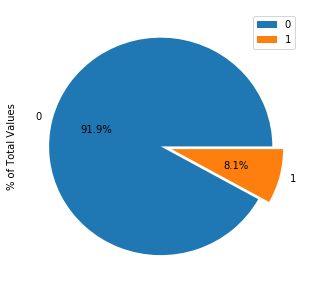

In [8]:
#Generate pie plot and save it in outputFolder
figure = value_df.plot.pie(y='% of Total Values', figsize= (5,5), explode=(0,0.1), autopct='%.1f%%').get_figure()
figure.savefig(outputFolder + os.sep + 'DataImbalance.png', dpi=200, format='png')

#### Save top and bottom 10 values in a csv. 

In [14]:
# Missing values statistics
missing_values = compute_missing_values(input_df)
missing_values.head(10).to_csv(outputFolder + os.sep + 'Top10MissingValues.csv')
missing_values.tail(10).to_csv(outputFolder + os.sep + 'Bottom10MissingValues.csv')

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


## Outliers detection and handling

In [18]:
#join train and test data sets for better visualization of outliers
training_df = readFile(dataFolder + '\\application_train.csv')
test_df = readFile(dataFolder + '\\application_test.csv')
combined_df = training_df.append(test_df)
print('Joined train rows {} with test rows {}. New total {}'.format(input_df.shape[0], app_test.shape[0],combined_df.shape[0]))

Joined train rows 307511 with test rows 48744. New total 356255


In [21]:
plot_feature_distribution(combined_df, 'DAYS_EMPLOYED')

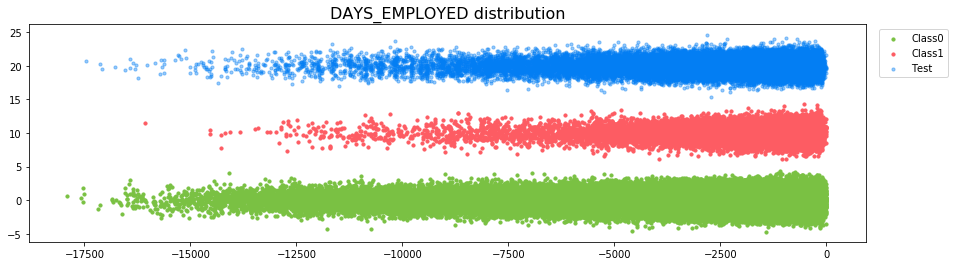

In [24]:
combined_df['DAYS_EMPLOYED'] = combined_df['DAYS_EMPLOYED'].map(lambda x: x if x <= 0 else np.nan)
plot_feature_distribution(combined_df, 'DAYS_EMPLOYED', '_corrected')

In [27]:
#Remove combined data frame to free up memory
del combined_df
gc.collect()

7

In [75]:
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)

## Data set version 1: with missing values as NaN
### Data set version 1_a: Null values without categorical features

In [118]:
#Version one with null values included and no categorical features.
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'])
input_df = drop_features(input_df, categorical_feats + bool_feats)

input_df.to_csv(outputFolder + '\\DataSetVersion1_a.csv')
input_df.info()
del input_df, categorical_feats, floatingPoint_feats, bool_feats, integer_feats
gc.collect()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
41 columns have been dropped from input data set
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Data columns (total 42 columns):
SK_ID_CURR                      307507 non-null int64
TARGET                          307507 non-null int64
CNT_CHILDREN                    307507 non-null int64
AMT_INCOME_TOTAL                307506 non-null float64
AMT_CREDIT                      307507 non-null float64
AMT_ANNUITY                     307495 non-null float64
AMT_GOODS_PRICE                 307229 non-null float64
REGION_POPULATION_RELATIVE      307507 non-null float64
DAYS_BIRTH                      307507 non-null int64
DAYS_EMPLOYED                   252133 non-null float64
DAYS_REGISTRATION               307507 non-null float64
DAYS_ID_PUBLISH                 307507 non-null int64
CNT_FAM_MEMBERS                 307505 non-null float64
REGION_RATING_CLIENT            30

28

### Data set version 1_b: Null values with categorical features OHE

In [119]:
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'])

input_df = pd.get_dummies(input_df, columns=categorical_feats, dtype=np.int64, dummy_na= True)

input_df.info()
input_df.to_csv(outputFolder + '\\DataSetVersion1_b.csv')
del input_df, categorical_feats, floatingPoint_feats, bool_feats, integer_feats
gc.collect()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
41 columns have been dropped from input data set
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Columns: 206 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_nan
dtypes: float64(28), int64(178)
memory usage: 485.6 MB


35

### Data set version 1_c: Null values with categorical feature WOE encoded

In [120]:
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)

categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'])
for cat_feature in categorical_feats:
    WoE_df = calculate_WOE(input_df, 'TARGET', cat_feature)
    input_df[cat_feature] = input_df[cat_feature].replace(WoE_df.set_index('Value')['WoE'])

input_df.info()
input_df.to_csv(outputFolder + '\\DataSetVersion1_c.csv')
del input_df, categorical_feats, floatingPoint_feats, bool_feats, integer_feats, WoE_df
gc.collect()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
41 columns have been dropped from input data set
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Data columns (total 81 columns):
SK_ID_CURR                      307507 non-null int64
TARGET                          307507 non-null int64
NAME_CONTRACT_TYPE              307507 non-null float64
CODE_GENDER                     307507 non-null float64
FLAG_OWN_CAR                    307507 non-null float64
FLAG_OWN_REALTY                 307507 non-null float64
CNT_CHILDREN                    307507 non-null int64
AMT_INCOME_TOTAL                307506 non-null float64
AMT_CREDIT                      307507 non-null float64
AMT_ANNUITY                     307495 non-null float64
AMT_GOODS_PRICE                 307229 non-null float64
NAME_TYPE_SUITE                 306215 non-null float64
NAME_INCOME_TYPE                307507 non-null float64
NAME_EDUCATION_TYPE           

70

## Data set version 2: With missing value entries omitted
### Data set version 2_a: Without categorical features 

In [121]:
#Version with no null values and categorical features.
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'])
input_df = drop_features(input_df, categorical_feats + bool_feats)
input_df = input_df.dropna()

input_df.to_csv(outputFolder + '\\DataSetVersion2_a.csv')
input_df.info()
del input_df, categorical_feats, floatingPoint_feats, bool_feats, integer_feats
gc.collect()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
41 columns have been dropped from input data set
<class 'pandas.core.frame.DataFrame'>
Int64Index: 101954 entries, 0 to 307510
Data columns (total 42 columns):
SK_ID_CURR                      101954 non-null int64
TARGET                          101954 non-null int64
CNT_CHILDREN                    101954 non-null int64
AMT_INCOME_TOTAL                101954 non-null float64
AMT_CREDIT                      101954 non-null float64
AMT_ANNUITY                     101954 non-null float64
AMT_GOODS_PRICE                 101954 non-null float64
REGION_POPULATION_RELATIVE      101954 non-null float64
DAYS_BIRTH                      101954 non-null int64
DAYS_EMPLOYED                   101954 non-null float64
DAYS_REGISTRATION               101954 non-null float64
DAYS_ID_PUBLISH                 101954 non-null int64
CNT_FAM_MEMBERS                 101954 non-null float64
REGION_RATING_CLIENT            10

28

### Data set version 2_b: With categorical features OHE

In [122]:
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'])
input_df = input_df.dropna()

input_df = pd.get_dummies(input_df, columns=categorical_feats, dtype=np.int64, dummy_na= True)

input_df.info()
input_df.to_csv(outputFolder + '\\DataSetVersion2_b.csv')
del input_df, categorical_feats, floatingPoint_feats, bool_feats, integer_feats
gc.collect()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
41 columns have been dropped from input data set
<class 'pandas.core.frame.DataFrame'>
Int64Index: 84570 entries, 0 to 307510
Columns: 201 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_nan
dtypes: float64(28), int64(173)
memory usage: 130.3 MB


35

### Data set version 2_c: With categorical features WOE Encoded

In [123]:
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)

categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'])
input_df = input_df.dropna()

for cat_feature in categorical_feats:
    WoE_df = calculate_WOE(input_df, 'TARGET', cat_feature)
    input_df[cat_feature] = input_df[cat_feature].replace(WoE_df.set_index('Value')['WoE'])

input_df.info()
input_df.to_csv(outputFolder + '\\DataSetVersion2_c.csv')
del input_df, categorical_feats, floatingPoint_feats, bool_feats, integer_feats, WoE_df
gc.collect()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
41 columns have been dropped from input data set
<class 'pandas.core.frame.DataFrame'>
Int64Index: 84570 entries, 0 to 307510
Data columns (total 81 columns):
SK_ID_CURR                      84570 non-null int64
TARGET                          84570 non-null int64
NAME_CONTRACT_TYPE              84570 non-null float64
CODE_GENDER                     84570 non-null float64
FLAG_OWN_CAR                    84570 non-null float64
FLAG_OWN_REALTY                 84570 non-null float64
CNT_CHILDREN                    84570 non-null int64
AMT_INCOME_TOTAL                84570 non-null float64
AMT_CREDIT                      84570 non-null float64
AMT_ANNUITY                     84570 non-null float64
AMT_GOODS_PRICE                 84570 non-null float64
NAME_TYPE_SUITE                 84570 non-null float64
NAME_INCOME_TYPE                84570 non-null float64
NAME_EDUCATION_TYPE             84570 non-nu

63

## Data set version 3: With missing values imputed
### Data set version 3_a: Without categorical features

In [124]:
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'])
input_df = drop_features(input_df, categorical_feats + bool_feats)
input_df = impute_features(input_df, 'All')
input_df.info()
input_df.to_csv(outputFolder + '\\DataSetVersion3_a.csv')
del input_df, categorical_feats, floatingPoint_feats, bool_feats, integer_feats
gc.collect()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
41 columns have been dropped from input data set
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Data columns (total 42 columns):
SK_ID_CURR                      307507 non-null int64
TARGET                          307507 non-null int64
CNT_CHILDREN                    307507 non-null float64
AMT_INCOME_TOTAL                307507 non-null float64
AMT_CREDIT                      307507 non-null float64
AMT_ANNUITY                     307507 non-null float64
AMT_GOODS_PRICE                 307507 non-null float64
REGION_POPULATION_RELATIVE      307507 non-null float64
DAYS_BIRTH                      307507 non-null float64
DAYS_EMPLOYED                   307507 non-null float64
DAYS_REGISTRATION               307507 non-null float64
DAYS_ID_PUBLISH                 307507 non-null float64
CNT_FAM_MEMBERS                 307507 non-null float64
REGION_RATING_CLIENT        

28

### Data set version 3_b: With categorical features OHE

In [125]:
#Nominal variables imputed by mode values and Numerical variables imputed by mean
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'], verbose = True)
    
input_df = impute_features(input_df, 'All')
    
input_df = pd.get_dummies(input_df, columns=categorical_feats, dtype=np.int64)
    
input_df.to_csv(outputFolder + '\\DataSetVersion3_b.csv')
input_df.info()
del input_df
gc.collect()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
41 columns have been dropped from input data set
Catagorical Features : 13, Floating Point Features : 28, Boolean Features : 26, Integer Features : 12, Total Count : 79
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Columns: 193 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: float64(40), int64(153)
memory usage: 455.1 MB


42

### Data set version 3_c: With categorical features WOE encoding

In [126]:
#Nominal variables imputed by mode values and Numerical variables imputed by mean
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'])
input_df = impute_features(input_df, 'All')
    
#Replace categorical columns with WOE columns
for cat_feature in categorical_feats:
    WoE_df = calculate_WOE(input_df, 'TARGET', cat_feature)
    input_df[cat_feature] = input_df[cat_feature].replace(WoE_df.set_index('Value')['WoE'])
    del WoE_df
    
input_df.to_csv(outputFolder + '\\DataSetVersion3_c.csv')
input_df.info()
del input_df, categorical_feats, floatingPoint_feats, bool_feats, integer_feats
gc.collect()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
41 columns have been dropped from input data set
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Data columns (total 81 columns):
SK_ID_CURR                      307507 non-null int64
TARGET                          307507 non-null int64
NAME_CONTRACT_TYPE              307507 non-null float64
CODE_GENDER                     307507 non-null float64
FLAG_OWN_CAR                    307507 non-null float64
FLAG_OWN_REALTY                 307507 non-null float64
CNT_CHILDREN                    307507 non-null float64
AMT_INCOME_TOTAL                307507 non-null float64
AMT_CREDIT                      307507 non-null float64
AMT_ANNUITY                     307507 non-null float64
AMT_GOODS_PRICE                 307507 non-null float64
NAME_TYPE_SUITE                 307507 non-null float64
NAME_INCOME_TYPE                307507 non-null float64
NAME_EDUCATION_TYPE         

35

## Version 4: Imputed and Scaled Numerical Features
### Data set version 4_a: Without categorical features

In [127]:
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'])
input_df = drop_features(input_df, categorical_feats + bool_feats)
input_df = impute_features(input_df, 'All')
input_df = scale_features(input_df, integer_feats + floatingPoint_feats)
input_df.info()
input_df.to_csv(outputFolder + '\\DataSetVersion4_a.csv')
del input_df, categorical_feats, floatingPoint_feats, bool_feats, integer_feats
gc.collect()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
41 columns have been dropped from input data set
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Data columns (total 42 columns):
SK_ID_CURR                      307507 non-null int64
TARGET                          307507 non-null int64
CNT_CHILDREN                    307507 non-null float64
AMT_INCOME_TOTAL                307507 non-null float64
AMT_CREDIT                      307507 non-null float64
AMT_ANNUITY                     307507 non-null float64
AMT_GOODS_PRICE                 307507 non-null float64
REGION_POPULATION_RELATIVE      307507 non-null float64
DAYS_BIRTH                      307507 non-null float64
DAYS_EMPLOYED                   307507 non-null float64
DAYS_REGISTRATION               307507 non-null float64
DAYS_ID_PUBLISH                 307507 non-null float64
CNT_FAM_MEMBERS                 307507 non-null float64
REGION_RATING_CLIENT        

28

### Data set version 4_b: With categorical features OHE

In [128]:
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'], verbose = True)
    
input_df = impute_features(input_df, 'All')
input_df = scale_features(input_df, integer_feats + floatingPoint_feats)
    
input_df = pd.get_dummies(input_df, columns=categorical_feats, dtype=np.int64)
    
input_df.to_csv(outputFolder + '\\DataSetVersion4_b.csv')
input_df.info()
del input_df
gc.collect()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
41 columns have been dropped from input data set
Catagorical Features : 13, Floating Point Features : 28, Boolean Features : 26, Integer Features : 12, Total Count : 79
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Columns: 193 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: float64(40), int64(153)
memory usage: 455.1 MB


42

### Data set version 4_c: With categorical features WoE Encoded

In [129]:
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'])
input_df = impute_features(input_df, 'All')
input_df = scale_features(input_df, integer_feats + floatingPoint_feats)
    
#Replace categorical columns with WOE columns
for cat_feature in categorical_feats:
    WoE_df = calculate_WOE(input_df, 'TARGET', cat_feature)
    input_df[cat_feature] = input_df[cat_feature].replace(WoE_df.set_index('Value')['WoE'])
    del WoE_df
    
input_df.to_csv(outputFolder + '\\DataSetVersion4_c.csv')
input_df.info()
del input_df
gc.collect()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
41 columns have been dropped from input data set
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Data columns (total 81 columns):
SK_ID_CURR                      307507 non-null int64
TARGET                          307507 non-null int64
NAME_CONTRACT_TYPE              307507 non-null float64
CODE_GENDER                     307507 non-null float64
FLAG_OWN_CAR                    307507 non-null float64
FLAG_OWN_REALTY                 307507 non-null float64
CNT_CHILDREN                    307507 non-null float64
AMT_INCOME_TOTAL                307507 non-null float64
AMT_CREDIT                      307507 non-null float64
AMT_ANNUITY                     307507 non-null float64
AMT_GOODS_PRICE                 307507 non-null float64
NAME_TYPE_SUITE                 307507 non-null float64
NAME_INCOME_TYPE                307507 non-null float64
NAME_EDUCATION_TYPE         

28

## Version 5: Impute and Scaled Numerical Features with Feature Selection
### Data set version 5_a: Without categorical features

In [130]:
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
input_df = input_df.drop(columns = 'SK_ID_CURR')
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'], verbose=True)
labels = input_df.pop('TARGET')

input_df = drop_features(input_df, categorical_feats)

feature_df = select_features(input_df, labels, min_votes = 4, drop_ratio = 0.5)

selected_features = feature_df[feature_df.Total >= 3].Feature.values

input_df = input_df[selected_features]
input_df = impute_features(input_df, features ='All')    
input_df = scale_features(input_df)

input_df['TARGET'] = labels 
input_df.to_csv(outputFolder + '\\DataSetVersion5_a.csv')
input_df.info()
del input_df
gc.collect()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
41 columns have been dropped from input data set
Catagorical Features : 13, Floating Point Features : 28, Boolean Features : 26, Integer Features : 12, Total Count : 79
Variance :  42 selected features out of 66
Pearson :  33 selected features out of 66
CHI2 :  33 selected features out of 66
Fitting estimator with 66 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
RFE :  33 selected features out of 33
RF :  66 selected features out of 30
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Data columns (total 36 columns):
EXT_SOURCE_3                   307507 non-null float64
EXT_SOURCE_2                   307507 non-null float64
DEF_30_CNT_SOCIAL_CIRCLE       307507 non-null float64
DAYS_LAST_PHONE_CHANGE         307507 non-null float64
DAYS_EMPLOYED                  307507 non-null float64
AMT_GOODS_PRIC

21

### Data set version 5_b: With categorical features OHE

In [131]:
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
input_df = input_df.drop(columns = 'SK_ID_CURR')
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'], verbose=True)
labels = input_df.pop('TARGET')

input_df = pd.get_dummies(input_df, columns=categorical_feats, dtype=np.int64)

feature_df = select_features(input_df, labels, min_votes = 4, drop_ratio = 0.5)

selected_features = feature_df[feature_df.Total >= 3].Feature.values
input_df = input_df[selected_features]

input_df = impute_features(input_df, features ='All')    
input_df = scale_features(input_df)

input_df['TARGET'] = labels 
input_df.to_csv(outputFolder + '\\DataSetVersion5_b.csv')
input_df.info()
del input_df
gc.collect()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
41 columns have been dropped from input data set
Catagorical Features : 13, Floating Point Features : 28, Boolean Features : 26, Integer Features : 12, Total Count : 79
Variance :  107 selected features out of 191
Pearson :  95 selected features out of 191
CHI2 :  95 selected features out of 191
Fitting estimator with 191 features.
Fitting estimator with 181 features.
Fitting estimator with 171 features.
Fitting estimator with 161 features.
Fitting estimator with 151 features.
Fitting estimator with 141 features.
Fitting estimator with 131 features.
Fitting estimator with 121 features.
Fitting estimator with 111 features.
Fitting estimator with 101 features.
RFE :  95 selected features out of 95
RF :  191 selected features out of 81
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Data columns (total 97 columns):
REG_CITY_NOT_LIVE_CITY                               30750

21

### Data set version 5_c: With categorical features WoE Encoded

In [132]:
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
input_df = input_df.drop(columns = 'SK_ID_CURR')
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'], verbose=True)

#Replace categorical columns with WOE columns
for cat_feature in categorical_feats:
    WoE_df = calculate_WOE(input_df, 'TARGET', cat_feature)
    input_df[cat_feature] = input_df[cat_feature].replace(WoE_df.set_index('Value')['WoE'])
    del WoE_df
    
labels = input_df.pop('TARGET')
feature_df = select_features(input_df, labels, min_votes = 4, drop_ratio = 0.5)

selected_features = feature_df[feature_df.Total >= 3].Feature.values
input_df = input_df[selected_features]

input_df = impute_features(input_df, features ='All')    
input_df = scale_features(input_df)

input_df['TARGET'] = labels 
input_df.to_csv(outputFolder + '\\DataSetVersion5_c.csv')
input_df.info()
del input_df
gc.collect()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
41 columns have been dropped from input data set
Catagorical Features : 13, Floating Point Features : 28, Boolean Features : 26, Integer Features : 12, Total Count : 79
Variance :  50 selected features out of 79
Pearson :  39 selected features out of 79
CHI2 :  39 selected features out of 79
Fitting estimator with 79 features.
Fitting estimator with 69 features.
Fitting estimator with 59 features.
Fitting estimator with 49 features.
RFE :  39 selected features out of 39
RF :  79 selected features out of 33
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Data columns (total 43 columns):
ORGANIZATION_TYPE              307507 non-null float64
OCCUPATION_TYPE                307507 non-null float64
NAME_INCOME_TYPE               307507 non-null float64
NAME_EDUCATION_TYPE            307507 non-null float64
EXT_SOURCE_3                   307507 non-null float64
EXT_SOURCE_2  

21

## Version 6: Balanced and Imbalanced Sampling
### Data set version 6_a: Balanced Samples with categorical features OHE

In [36]:
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
input_df = input_df.drop(columns = 'SK_ID_CURR')
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'], verbose=True)
labels = input_df.pop('TARGET')

input_df = pd.get_dummies(input_df, columns=categorical_feats, dtype=np.int64)

input_df = impute_features(input_df, features ='All')    
input_df = scale_features(input_df)

sampled_df , sampled_labels = take_sample(input_df, labels, stratified = False)
sampled_df['TARGET'] = sampled_labels
sampled_df.to_csv(outputFolder + '\\DataSetVersion6_a.csv')
sampled_df.info()
del input_df, sampled_df, labels
gc.collect()

Catagorical Features : 16, Floating Point Features : 66, Boolean Features : 26, Integer Features : 12, Total Count : 120
label 1 sample size: 24825
label 0 sample size: 24825
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49650 entries, 74554 to 187706
Columns: 244 entries, CNT_CHILDREN to TARGET
dtypes: float64(243), int64(1)
memory usage: 92.8 MB


49

### Data set version 6_b: Unbalanced sample with categorical features OHE

In [37]:
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
input_df = input_df.drop(columns = 'SK_ID_CURR')
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'], verbose=True)
labels = input_df.pop('TARGET')

input_df = pd.get_dummies(input_df, columns=categorical_feats, dtype=np.int64)

input_df = impute_features(input_df, features ='All')    
input_df = scale_features(input_df)

sampled_df , sampled_labels = take_sample(input_df, labels)
sampled_df['TARGET'] = sampled_labels
sampled_df.to_csv(outputFolder + '\\DataSetVersion6_b.csv')
sampled_df.info()
del input_df, sampled_df, labels
gc.collect()

Catagorical Features : 16, Floating Point Features : 66, Boolean Features : 26, Integer Features : 12, Total Count : 120
label 1 sample size: 2004
label 0 sample size: 22821
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24825 entries, 46834 to 231622
Columns: 244 entries, CNT_CHILDREN to TARGET
dtypes: float64(243), int64(1)
memory usage: 46.4 MB


56